In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/reverse_image_search_engine_2

/content/drive/MyDrive/reverse_image_search_engine_2


In [ ]:
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

In [ ]:
!pwd

/content/drive/MyDrive/reverse_image_search_engine_2


used Caltech101 object dataset.The pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. Collected in September 2003 by Fei-Fei Li, Marco Andreetto, and Marc::: ‘Aurelio Ranzato. The size of each image is roughly 300 x 200 pixels.

Dataset Link: https://data.caltech.edu/records/20086


In [ ]:
#unzip the tar.gz file
!tar -xvf /content/drive/MyDrive/reverse_image_search_engine_2/101_ObjectCategories.tar.gz

Streaming output truncated to the last 5000 lines.
101_ObjectCategories/chair/image_0005.jpg
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chai

In the dataset there is a ‘Background google’ folder which contains random google images remove it.

In [ ]:
!rm -rf /content/drive/MyDrive/reverse_image_search_engine_2/101_ObjectCategories/BACKGROUND_Google

Used Resnet50 model which is pre-trained on the imagenet dataset (http://www.image-net.org/) to extract the features from the Caltech101 images dataset. In other words we will convert the images in the dataset to feature vectors using Resnet50.

## Why resnet ?
resnet because of the relatively small feature size. It converts images into 2048 convolutional features compared to 25088 features in vgg 19 or 51200 features in inception architectures. It will be easy for the nearest neighbor algorithm to find neighbors and also it will minimize the effects of Curse_of_dimensionality.




Creating Resnet50 model without top layers so we get convolutional features as output instead of the image class probability.

In [ ]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

creating a Keras image data generator object and preprocessing the images.After that we are passing the data generator object to the ResNet-50 model to extract the features.

In [ ]:
batch_size = 64
root_dir = '101_ObjectCategories'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict_generator(datagen, num_epochs)
print("Num images = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)
Num_images   =  8677
Shape_of_feature_list =  (8677, 2048)

Found 8677 images belonging to 101 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


Num images =  8677
Shape of feature_list =  (8677, 2048)


We have 8677 images in our dataset after removing the google background images. 

Each image is converted into a 2048 feature vector.

In [ ]:
# Get full path for all the images in our dataset
filenames = [root_dir + '/' + s for s in datagen.filenames]

Fitting the nearest neighbor algorithm to the extracted features.I have picked ball_tree algorithm as it works well with sparse data

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)


NearestNeighbors(algorithm='ball_tree', metric='euclidean')

Let’s pick a new image that is not present in our dataset and try to find similar images for it.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ant.jpg to ant.jpg


Once the image is uploaded extract the features for the image using the ResNet-50 and find the nearest neighbors for it.

In [ ]:
# ref https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model
img_path = 'ant.jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

plot the images

In [ ]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

With the nearest neighbors indices provided by the model let’s find out the images similar to the one it uploaded.

(1, 5)


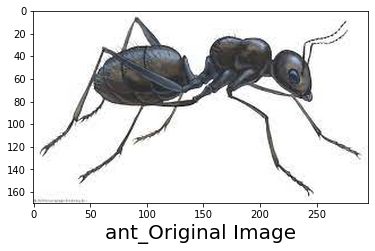

Predictions images


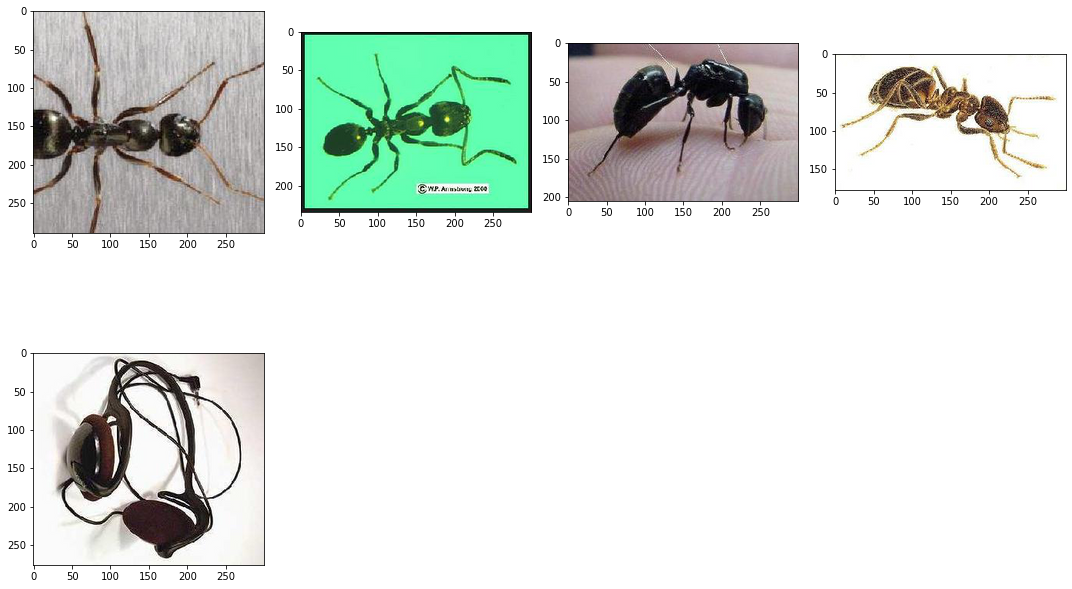

In [ ]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('Predictions images')
similar_images(indices[0])

I observe that the image of a headphone in the similarity images which is incorrect. Due to the large dimensionality of the features, the NearestNeighbors algorithm is not able to cluster similar features accurately.



To overcome this applied PCA to our features and reduce the dimensions and try to find similar features again.

In [ ]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

Fit the nearest neighbors algorithm to the new features.



In [ ]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',metric='euclidean')
neighbors_pca_features.fit(compressed_features)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

Transform the test image features as well and try to find similar images.


(1, 5)


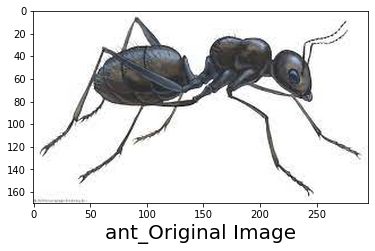

Predictions images


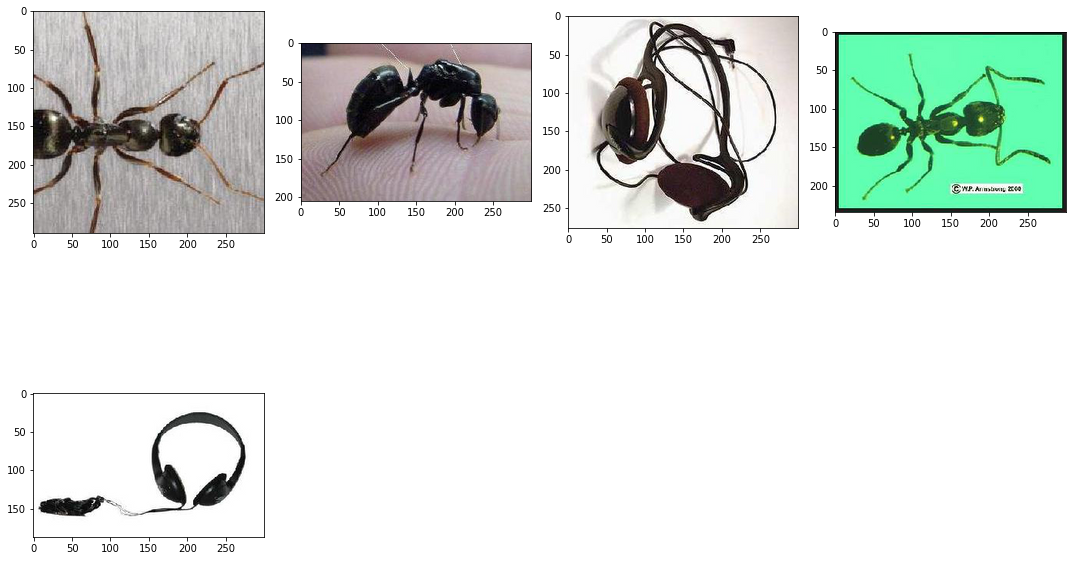

In [ ]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('Predictions images')
similar_images(indices[0])

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving butterfly.jpg to butterfly.jpg


In [ ]:
# ref https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model
img_path = 'butterfly.jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

In [ ]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

(1, 5)


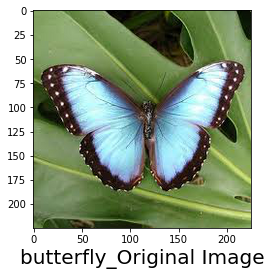

 Predictions images


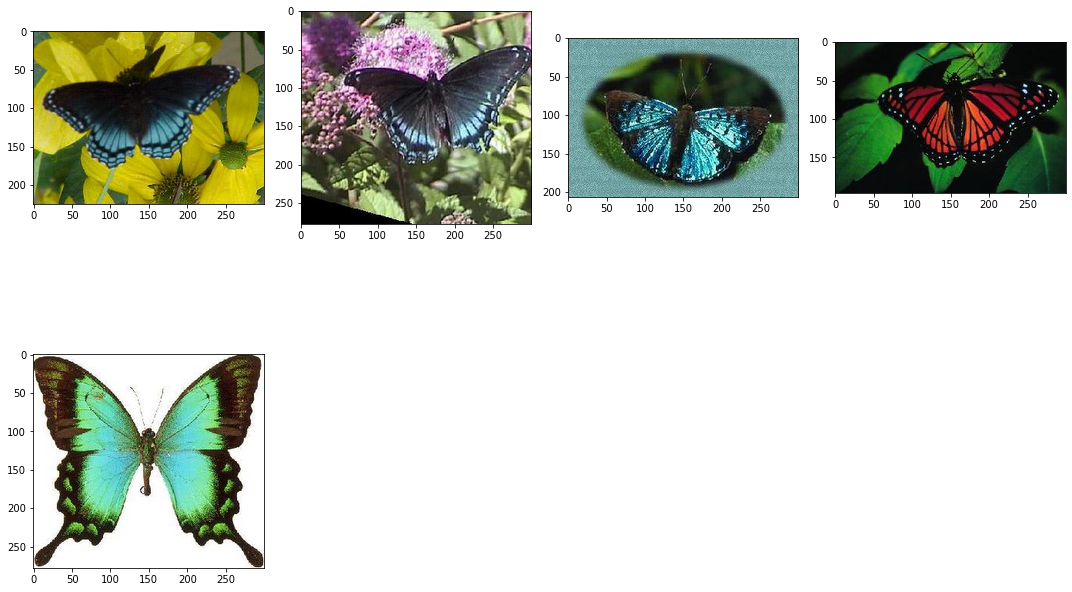

In [ ]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print(' Predictions images')
similar_images(indices[0])

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving aeroplane.jpg to aeroplane.jpg


In [ ]:
# ref https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model
img_path = 'aeroplane.jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

In [ ]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

(1, 5)


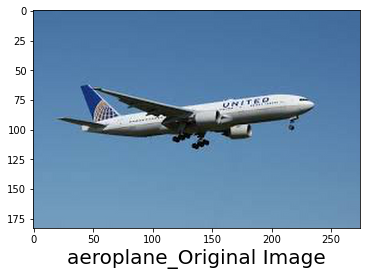

 Predictions images


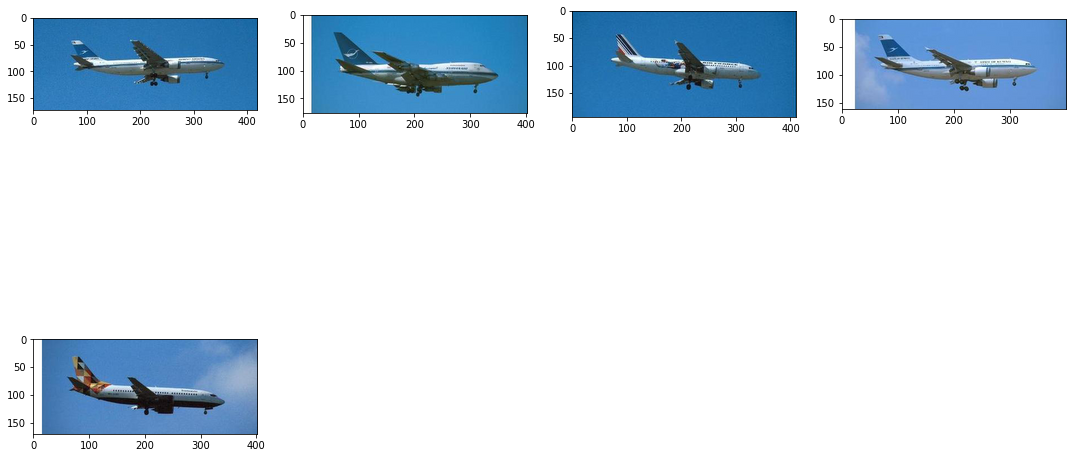

In [ ]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print(' Predictions images')
similar_images(indices[0])